
Fixar os parâmetros do modelo dinâmico e procurar apenas os parâmetros da lente.


In [5]:
#Para isso, primeiro plotamos o resultado do  modelo dinâmico

#General packages
import numpy as np
from My_Jampy import JAM
import matplotlib.pyplot as plt

#Constants and usefull packages
from astropy.cosmology import Planck15 as cosmo
from astropy.constants import G, M_sun, c
import astropy.units as u

from os import path
dataset_path = "/home/carlos/Documents/GitHub/Master-Degree/ESO325/Arcs Modelling/autolens_workspace/JAM+Pyautolens/Data"

#Reading data
y_px, x_px, vrms, erms = np.loadtxt('pPXF_rot_data.txt', unpack=True)                  #pPXF
surf_star_dat, sigma_star_dat, qstar_dat = np.loadtxt('JAM_Input.txt', unpack=True)    #photometry
surf_DM_dat, sigma_DM_dat, qDM_dat  = np.loadtxt('pseudo-DM Input.txt', unpack=True)   #DM

In [6]:
### Global Constantes

#Redshifth

z_galaxy = 0.035                                 #galaxy redshifth

#Angular diameter distances
D_l = cosmo.angular_diameter_distance(z_galaxy)                       


#Useful constants
metre2Mpc = (1*u.m).to(u.Mpc)/u.m           #Constant factor to convert metre to Mpc.
kg2Msun = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun

G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s

jam_axi_rms elapsed time sec: 0.58
inc=89.7 beta_z=-0.46 M/L=1 BH=5.89e+07 chi2/DOF=3.09
Total mass MGE: 6.692e+11


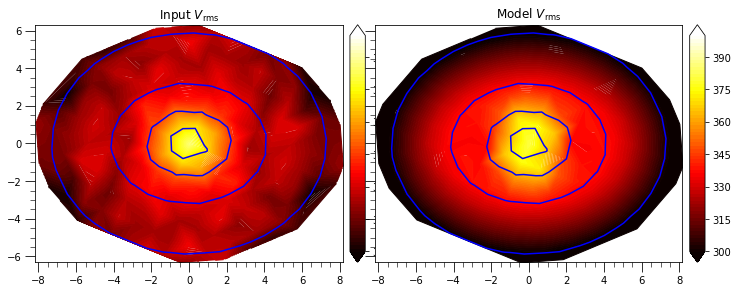

In [7]:
#Galaxy
distance = D_l                                              #Angular diameter distance [Mpc]
inc = 89.74                                                   #Inclination [deg]
mbh =  (10**(7.77))*u.solMass                                        #Mass of black hole [M_sun]
beta0 = np.array([-0.46, -0.64, 0.72, -3.35, 0.37, 0.09, 0.05])                #Anisotropy parameter, one for each gaussian component

ML0 = np.array([6.75, 6.75, 5.48, 5.36, 5.32, 5.30, 5.29])*u.solMass/u.solLum       #Mass-to-light ratio per gaussian [M_sun/L_sun]


#DM
surf_DM_dat = (10**(9.21))*surf_DM_dat*(u.solMass/u.pc**2)                          #Surface Density in M_sun/pc²
sigma_DM_dat_ARC = sigma_DM_dat*u.arcsec                               #Sigma in arcsec
sigma_DM_dat_PC = (sigma_DM_dat_ARC*D_l).to(u.pc, u.dimensionless_angles())    #Convert sigma in arcsec to sigma in pc
qDM_dat = np.ones_like(qDM_dat)*0.61                                                              #axial ratio of DM halo

#Stars
surf_star_dat = surf_star_dat*(u.solLum/u.pc**2)               #Surface luminosity Density in L_sun/pc²
sigma_star_dat_ARC = sigma_star_dat*u.arcsec                   #Sigma in arcsec
sigma_star_dat_PC = (sigma_star_dat_ARC*D_l).to(u.pc, u.dimensionless_angles()) #Convert sigma in arcsec to sigma in pc
qstar_dat = qstar_dat                                          #axial ratio of star photometry



#----------------------------------------------------------------------------------------------------#


# JAMPY MODEL

#Defining some instrumental quantities and galaxy characteristics

muse_pixsize=0.6                                            #pixscale of IFU [arcsec/px]
muse_sigmapsf= 0.2420                                       #Sigma of psf from MUSE [arcsec]


#Create model
Jampy_model = JAM(ybin=y_px, xbin=x_px,inc=inc, distance=distance.value, mbh=mbh.value,
                  rms=vrms, erms=erms, beta=beta0, sigmapsf=muse_sigmapsf, pixsize=muse_pixsize)

#Add Luminosity component
Jampy_model.luminosity_component(surf_lum=surf_star_dat.value, sigma_lum=sigma_star_dat_ARC.value,
                                    qobs_lum=qstar_dat, ml=ML0.value)

#Add Dark Matter component
Jampy_model.DM_component(surf_dm=surf_DM_dat.value, sigma_dm=sigma_DM_dat_ARC.value, qobs_dm=qDM_dat)
plt.figure(figsize=(12,12))
Jampy_model.run(plot=True, quiet=False, vmax=400, vmin=300)

plt.show()

In [8]:
#Agora construímos o modelo de lentes

#Autolens Model packages

import autolens as al
import autolens.plot as aplt

#Constants and usefull packages
from astropy.cosmology import Planck15 as cosmo
from astropy.constants import G, M_sun, c
import astropy.units as u

In [9]:
#Lens parameters

z_lens = 0.035                                #Lens redshifth
z_source = 2.1                                #Source redshift

#Angular diameter distances
D_l = cosmo.angular_diameter_distance(z_lens)                       
D_s = cosmo.angular_diameter_distance(z_source)
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

In [10]:
# Pyautolens Model

#Convert  surf_DM_dat to total mass per Guassian
Mass_DM_dat = 2*np.pi*surf_DM_dat*(sigma_DM_dat_PC**2)*qDM_dat     #Total mass per gaussian component in M_sun


#Convert surf_star_dat to total Luminosity per Guassian and then to total mass per gaussian
Lum_star_dat = 2*np.pi*surf_star_dat*(sigma_star_dat_PC**2)*qstar_dat    #Total luminosity per gaussian component in L_sun



#Update the stellar mass based on M/L.
Mass_star_dat = Lum_star_dat*ML0                          #Total star mass per gaussian in M_sun

#Inserting a Gaussian to represent SMBH at the center of the galaxy
sigmaBH_ARC = 0.01*u.arcsec
"""
        This scalar gives the sigma in arcsec of the Gaussian representing the
        central black hole of mass MBH (See Section 3.1.2 of `Cappellari 2008.
        <http://adsabs.harvard.edu/abs/2008MNRAS.390...71C>`_)
        The gravitational potential is indistinguishable from a point source
        for ``radii > 2*RBH``, so the default ``RBH=0.01`` arcsec is appropriate
        in most current situations.

        ``RBH`` should not be decreased unless actually needed!
"""


sigmaBH_PC = (sigmaBH_ARC*D_l).to(u.pc, u.dimensionless_angles())        #Sigma of the SMBH in pc
surfBH_PC = mbh/(2*np.pi*sigmaBH_PC**2)                                  #Mass surface density of SMBH
qSMBH = 1.                                                               #Assuming a circular gaussian
Mass_SMBH_dat = 2*np.pi*surfBH_PC*(sigmaBH_PC**2)*qSMBH                  #SMBH Total mass 

In [11]:
#Defining the general inputs for the model

i = np.deg2rad(inc)*u.rad                                         #Inclination angle in rad
Total_Mass = np.concatenate((Mass_star_dat, Mass_DM_dat,
                                 Mass_SMBH_dat), axis=None)       #Mass per gaussian component in M_sun
Total_q = np.concatenate((qstar_dat, qDM_dat, qSMBH), axis=None)  #Total axial ratio per gaussian


#Total_q_proj = np.sqrt(Total_q**2 - np.cos(i)**2)/np.sin(i)    #Total projected axial ratio per gaussian
Total_sigma_ARC = np.concatenate((sigma_star_dat_ARC, sigma_DM_dat_ARC, sigmaBH_ARC), axis=None)  #Total sigma per gaussian in arcsec
Total_sigma_RAD = Total_sigma_ARC.to(u.rad)                    #Total sigma per gaussian in radians

In [12]:
#Reading fits file with the arcs data

dataset_type = "JAM+Pyautolens"
dataset_name = "Data"
dataset_path = f"/home/carlos/Documents/GitHub/Master-Degree/ESO325/Arcs Modelling/autolens_workspace/{dataset_type}/{dataset_name}"

#Load data
imaging = al.Imaging.from_fits(
        image_path=f"{dataset_path}/arcs_resized.fits",
        noise_map_path=f"{dataset_path}/noise_map_resized.fits",
        psf_path=f"{dataset_path}/psf.fits",
        pixel_scales=0.04,
    )

In [13]:
#aplt.Imaging.subplot_imaging(imaging)

In [23]:
#Load mask
mask_custom = al.Mask.from_fits(
    file_path=f"{dataset_path}/mask_gui_2.fits", hdu=0, pixel_scales=imaging.pixel_scales
)

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask_custom, inversion_uses_border=False)

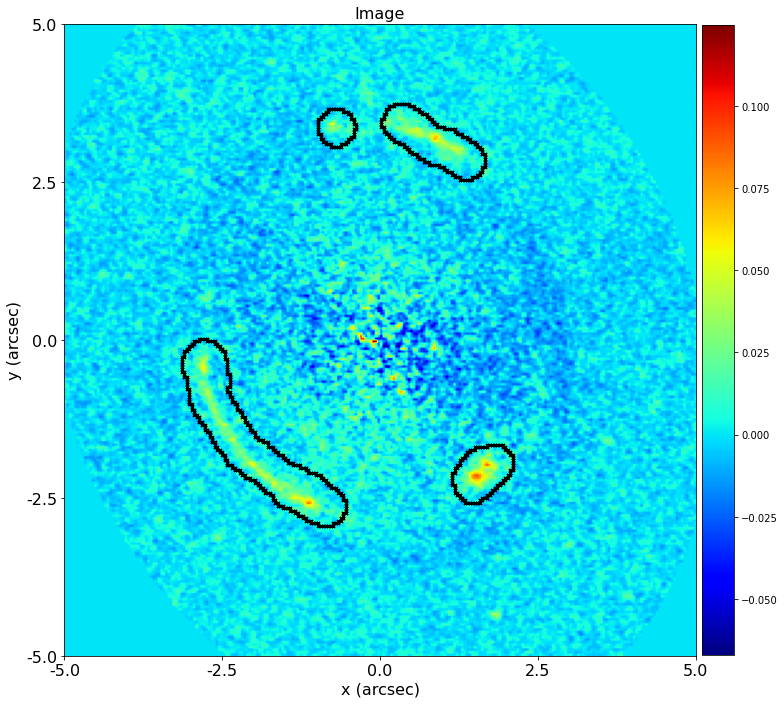

In [24]:
plt.figure(figsize=(12,12))
aplt.Imaging.image(imaging=imaging, mask=mask_custom, include=aplt.Include(border=False))

In [29]:
# __Defining the MGE mass model__

#Initializing the MGE model for the lens

mass_profile = al.mp.MGE(centre=(0.0, 0.0))                             #Mass model
mass_profile.MGE_comps(M=Total_Mass.value, sigma=Total_sigma_RAD.value,
                       q=Total_q, z_l=z_lens, z_s=z_source)  #Input parameters

mass_profile.MGE_Grid_parameters(masked_imaging.grid)               #Grid with the data

#Lens Model
lens_galaxy = al.Galaxy(                                            
        redshift=0.035,
        mass=mass_profile,
        shear=al.mp.ExternalShear(elliptical_comps=(0,0)),
    )

In [30]:
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=2.1)], )
source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]

Entrou
MainProcess 3.7119977474212646


In [31]:
rectangular = al.pix.Rectangular(shape=(40, 40))
mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)
    
inversion = al.Inversion(
        masked_dataset=masked_imaging,
        mapper=mapper,
        regularization=al.reg.Constant(coefficient=3.5,),
    )

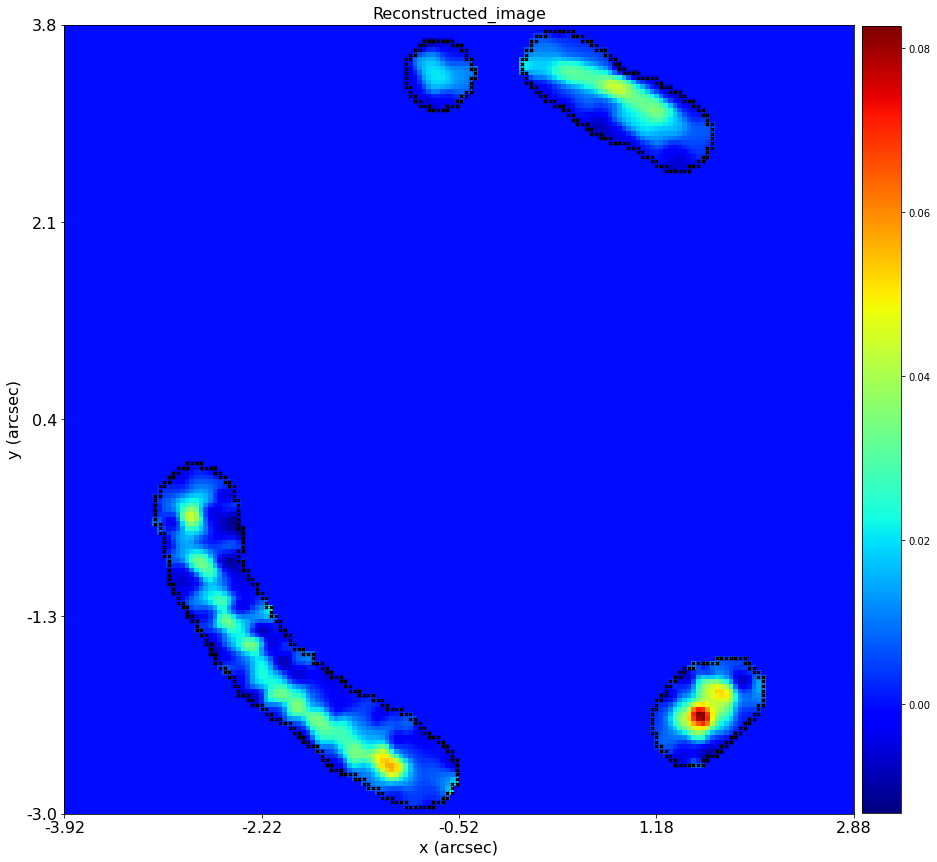

In [36]:
plt.figure(figsize=(15,15))
aplt.Inversion.reconstructed_image(inversion=inversion)

In [37]:
help(al.convert.shear_elliptical_comps_from)

Help on function shear_elliptical_comps_from in module autogalaxy.util.convert:

shear_elliptical_comps_from(magnitude, phi)
    :param phi: angel
    :param magnitude: ellipticity
    :return:



In [49]:
shear = al.convert.shear_elliptical_comps_from(magnitude=0.2, phi=100)

In [47]:
al.convert.shear_magnitude_and_phi_from(el)

(0.2, 99.99999999999999)

In [45]:
el = [-0.06840402866513373, -0.1879385241571817]

In [50]:
lens_galaxy = al.Galaxy(                                            
        redshift=0.035,
        mass=mass_profile,
        shear=al.mp.ExternalShear(shear),
    )

In [51]:
lens_galaxy

Redshift: 0.035
Mass Profiles:
MGE
centre: (0.0, 0.0)
processes: 1
method: quadva
gamma: 1.0
M: [2.67293661e+08 1.44783363e+09 1.42230916e+10 3.21234929e+10
 7.74686549e+10 1.30415884e+11 4.12989411e+11 8.10984410e-03
 2.59500385e-02 2.18379846e-03 2.80206791e-03 7.68974705e-02
 1.67055852e-01 6.60715592e-02 4.74427004e-01 1.94552379e-01
 9.36998851e-01 7.44919090e-01 1.75493053e+00 5.04472912e+00
 7.01936407e+00 6.76581884e+00 6.21849081e+00 2.67354358e+01
 5.42333272e+01 1.10889888e+02 1.70103196e+02 1.39301737e+02
 5.34980764e+02 3.13235894e+02 1.29689901e+03 1.52143813e+03
 2.36163678e+03 7.49677097e+03 2.85336064e+03 2.49102746e+04
 8.90936451e+03 1.20383168e+05 4.42782988e+05 1.33199846e+05
 4.06922349e+06 3.00038490e+05 1.59113915e+08 5.88843655e+07]
sigma: [1.84714013e-07 8.54479265e-07 1.82864448e-06 3.41875579e-06
 6.40943079e-06 1.31994209e-05 3.44875412e-05 4.76368615e-10
 9.49834359e-10 1.08003156e-09 1.56209053e-09 1.74871713e-09
 2.88385503e-09 3.49864096e-09 4.84046609e